In [2]:
# Notebook: USA / PL COVID-19 kohorts analysis
# Description: Notebook contains analysis od DMPs identified in USA and PL COVID-19 vs Healthy controls

In [3]:
%load_ext lab_black

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [91]:
def extract(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["Delta mean"].abs() > 0.1) & (df["q-value"] <= 0.05)]


def perform_clustering(df: pd.DataFrame, poi_column: str = "POI", path: str = None):
    pal = sns.color_palette("Accent", df[poi_column].nunique())
    lut = dict(zip(map(str, df[poi_column].unique()), pal))
    colors = df[poi_column].map(lut)
    colors.name = ""

    sns.set(font_scale=1.4)
    df.index.name = ""
    fig = sns.clustermap(
        df.drop(poi_column, axis=1).T, method="ward", cmap="vlag", col_colors=colors
    )

    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(
        handles,
        lut,
        title=poi_column,
        bbox_to_anchor=(1, 1),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )

    plt.show()

    if path:
        fig.savefig(path)


def perform_tSNE(df: pd.DataFrame, poi_column: str = "POI", path: str = None):
    tsne = TSNE(n_components=2, method="exact", random_state=101)

    transformed = tsne.fit_transform(df.drop(poi_column, axis=1))
    transformed = pd.DataFrame(transformed, index=df.index, columns=["C1", "C2"])
    transformed = pd.concat((transformed, df["POI"]), axis=1)

    fig = px.scatter(
        transformed, x="C1", y="C2", color="POI", hover_name=transformed.index
    )

    fig.update_layout(legend=dict(font=dict(size=24), title=""), font=dict(size=22))
    fig.update_traces(marker=dict(size=10))

    if path:
        fig.write_image(path)

    fig.show()

In [80]:
# USA kohort analysis

In [92]:
mynorm_usa = pd.read_csv(
    "../data/processed/CorrectedMyNorms/mynorm_USA.csv", index_col=0
)
usa_dmps = pd.read_csv(
    "../Notebooks/statistics/output/USACoV_vs_HB_ALLProbes.csv", index_col=0
)

sample_names = dict(
    pd.read_csv("../data/raw/Annotations/FromGEO_GSE174818.csv", index_col=0)["ID"]
)

usa_dmps = extract(usa_dmps)
mynorm_usa = mynorm_usa.loc[usa_dmps.index].T

mynorm_usa.index = [
    sample_names.get(name) if name in sample_names.keys() else name
    for name in mynorm_usa.index
]  # Convert GSE to IDs

In [93]:
usa_dmps

,p-value,Control CpG mean,Control CpG error,Target CpG mean,Target CpG error,Min target sample size,Min control sample size,Status,Delta mean,q-value
CpG,,,,,,,,,,
cg03860054,2.964261e-15,0.758395,0.008262,0.654009,0.007415,9,9,Hypomethylated,-0.104385,9.199869e-13
cg25060243,1.697288e-18,0.815479,0.008884,0.696132,0.007129,8,11,Hypomethylated,-0.119346,2.005973e-14
cg23375379,6.618494e-16,0.745407,0.008974,0.642532,0.006094,6,11,Hypomethylated,-0.102875,3.471554e-13
cg12045156,6.776869e-14,0.593641,0.010492,0.482378,0.007105,8,15,Hypomethylated,-0.111264,9.038609e-12
cg27323430,3.634524e-13,0.790869,0.010124,0.679863,0.009171,14,14,Hypomethylated,-0.111006,3.325297e-11
...,...,...,...,...,...,...,...,...,...,...
cg04204557,1.187069e-16,0.674939,0.011650,0.544362,0.007695,10,18,Hypomethylated,-0.130577,1.286739e-13
cg05523603,2.932098e-10,0.595419,0.008743,0.493694,0.011460,21,10,Hypomethylated,-0.101725,8.203907e-09
cg06656458,1.462368e-17,0.817983,0.008476,0.707207,0.006571,7,10,Hypomethylated,-0.110776,4.540521e-14


In [94]:
mynorm_usa["POI"] = mynorm_usa.index.map(
    lambda name: "Healthy controls"
    if name.startswith("HB")
    else ("COVID-19 USA" if name.startswith("C") else "non-COVID-19")
)

mynorm_usa = mynorm_usa[mynorm_usa["POI"] != "non-COVID-19"]

In [95]:
mynorm_usa.POI.value_counts()

COVID-19 USA        102
Healthy controls     83
Name: POI, dtype: int64

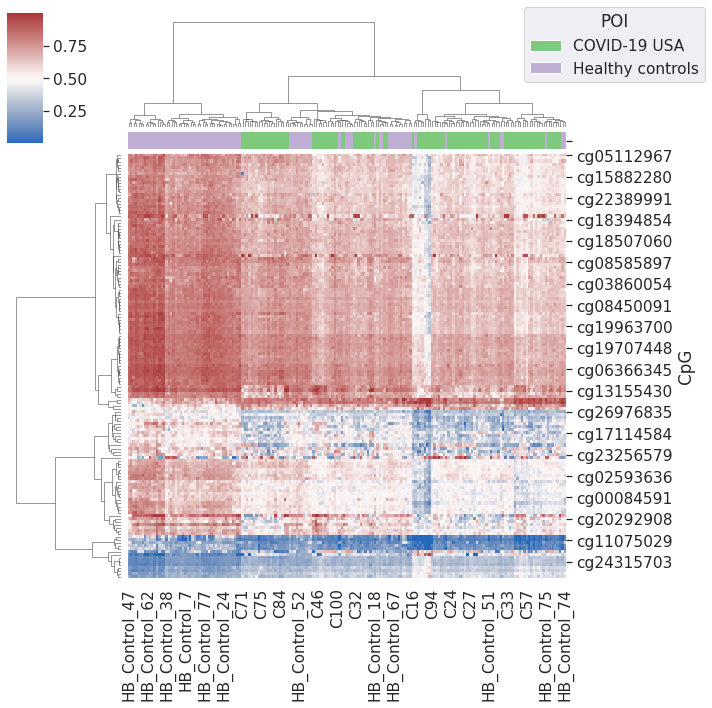

In [96]:
perform_clustering(mynorm_usa, path="../Plots/USA_kohort_clustering.jpg")

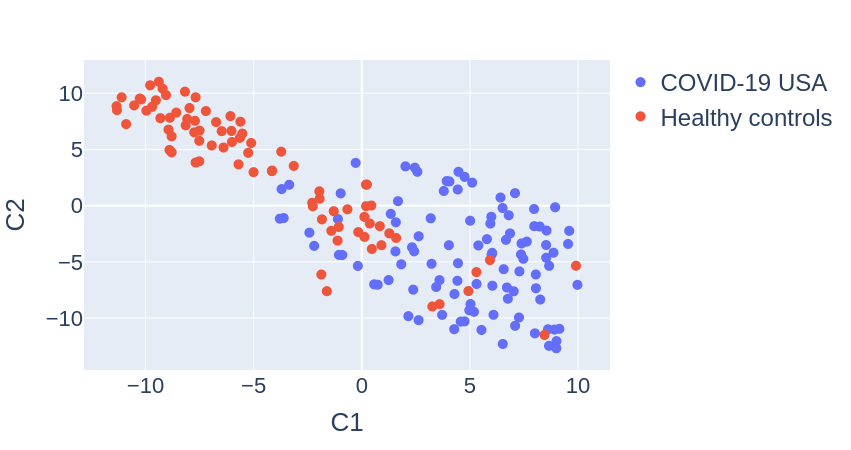

In [97]:
perform_tSNE(mynorm_usa, path="../Plots/USA_kohort_tSNE.jpg")

In [98]:
# PL COVID-19 kohort

In [99]:
pl_mynorm = pd.read_csv("../data/processed/CorrectedMyNorms/mynorm_PL.csv", index_col=0)
pl_report = pd.read_csv("statistics/output/PLCoV_vs_HB_ALLProbes.csv", index_col=0)
pl_report = extract(pl_report)

pl_mynorm = pl_mynorm.loc[pl_report.index, :].T

In [100]:
pl_report

,p-value,Control CpG mean,Control CpG error,Target CpG mean,Target CpG error,Min target sample size,Min control sample size,Status,Delta mean,q-value
CpG,,,,,,,,,,
cg00403186,2.721312e-09,0.767582,0.006389,0.643181,0.017838,16,6,Hypomethylated,-0.124400,3.971214e-08
cg25326740,2.791276e-12,0.047095,0.004097,0.148747,0.011033,6,3,Hypermethylated,0.101652,1.583921e-10
cg05484920,1.609578e-12,0.063720,0.003558,0.163767,0.010741,6,2,Hypermethylated,0.100047,1.023643e-10
cg00362680,6.665950e-11,0.876599,0.005100,0.773328,0.011771,7,4,Hypomethylated,-0.103271,1.965088e-09
cg13550873,6.012510e-14,0.857440,0.005876,0.693383,0.014688,11,5,Hypomethylated,-0.164057,8.258350e-12
...,...,...,...,...,...,...,...,...,...,...
cg20546365,1.423095e-15,0.111734,0.009000,0.413040,0.018292,17,11,Hypermethylated,0.301306,5.191913e-13
cg14540736,5.641119e-11,0.733493,0.009149,0.597615,0.016180,13,11,Hypomethylated,-0.135878,1.717844e-09
cg09057517,2.773475e-06,0.233995,0.012097,0.342337,0.018862,18,19,Hypermethylated,0.108342,1.260911e-05


In [101]:
pl_mynorm["POI"] = [
    "COVID-19 PL" if name.startswith("P") else "Healthy controls"
    for name in pl_mynorm.index
]

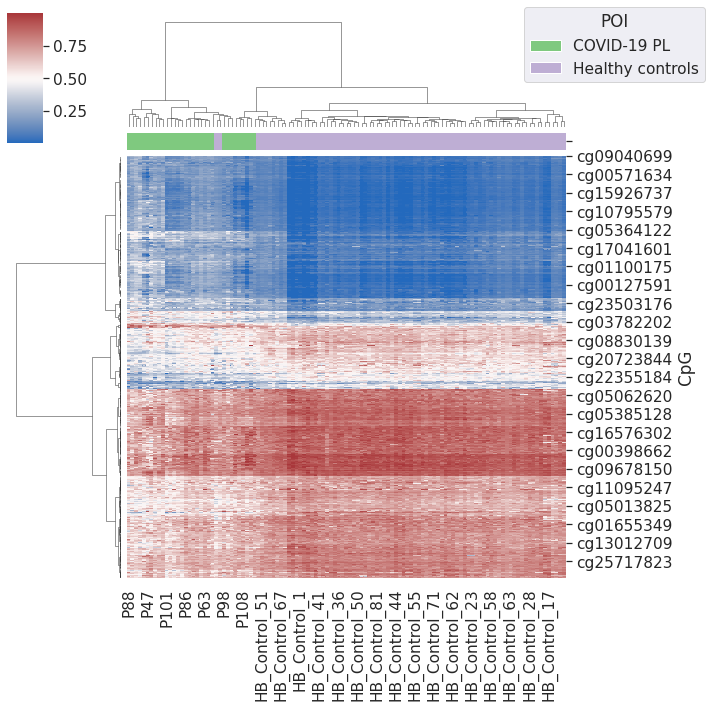

In [102]:
perform_clustering(pl_mynorm, path="../Plots/PL_kohort_clustering.jpg")

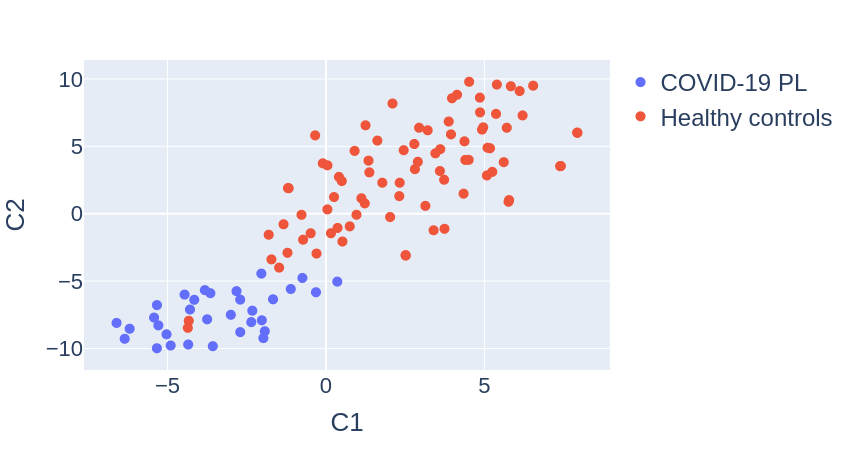

In [103]:
perform_tSNE(pl_mynorm, path="../Plots/PL_kohort_tSNE.jpg")